# ML勉強会03
## mnistの手書き文字認識を使って、ディープラーニングを理解してみる
### データセット
- MNISTの手書き文字 http://yann.lecun.com/exdb/mnist/

### 参考
- [ゼロから作る DeepLearning](https://www.oreilly.co.jp/books/9784873117584/)

### おまじない

In [1]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

In [2]:
%matplotlib inline

## データセットの読み込み
- mnistでダウンロードしたTraining用のラベル、画像、Test用のラベル、画像を読み込ませる
- なお、ラベルは通常の数値ではなく、1-hot表現で取り込んでいる。
- 1-hot表現は例えば7なら[0,0,0,0,0,0,0,1,0,0]のように正解のところにbitが立っていて、それ以外はゼロとなるような表現のことを言う

### Load Labels(Training Data)

In [3]:
file = gzip.open("mnist/train-labels-idx1-ubyte.gz", "rb")
label_data = file.read()
file.close()
magic = int.from_bytes(label_data[0:4], byteorder='big')
num_of_data = int.from_bytes(label_data[4:8], byteorder='big')
print(magic)
print(num_of_data)
t_train  = np.ndarray((num_of_data,10), dtype='uint8')
offset = 8
for i in range(0, num_of_data):
  t_train [i] = np.zeros(10,dtype="int8")
  t_train [i][label_data[offset+i]] = 1

print ("shape: {}".format(t_train.shape))

2049
60000
shape: (60000, 10)


### Load Image(Training Data)

In [4]:
file = gzip.open("mnist/train-images-idx3-ubyte.gz", "rb")
dataset = file.read()
file.close()
magic = int.from_bytes(dataset[0:4], byteorder='big')
num_of_data = int.from_bytes(dataset[4:8], byteorder='big')
num_of_rows = int.from_bytes(dataset[8:12], byteorder='big')
num_of_cols = int.from_bytes(dataset[12:16], byteorder='big')
print(magic)
print(num_of_data)
print(num_of_rows)
print(num_of_cols)
data_size = num_of_rows * num_of_cols
x_train = np.ndarray((num_of_data, data_size), dtype='uint8')
offset = 16
for i in range(0, num_of_data):
    for j in range(0, data_size):
      x_train[i][j] = dataset[offset+i*data_size+j]

print ("shape: {}".format(x_train.shape))

2051
60000
28
28
shape: (60000, 784)


### Load Labels (Test Label)

In [5]:
file = gzip.open("mnist/t10k-labels-idx1-ubyte.gz", "rb")
label_data = file.read()
file.close()
magic = int.from_bytes(label_data[0:4], byteorder='big')
num_of_data = int.from_bytes(label_data[4:8], byteorder='big')
print(magic)
print(num_of_data)
t_test = np.ndarray((num_of_data,10), dtype='int8')
offset = 8
for i in range(0, num_of_data):
  t_test [i] = np.zeros(10,dtype="uint8")
  t_test [i][label_data[offset+i]] = 1

print ("shape: {}".format(t_test.shape))

2049
10000
shape: (10000, 10)


### Load Data(Test Data)

In [6]:
file = gzip.open("mnist/t10k-images-idx3-ubyte.gz", "rb")
dataset = file.read()
file.close()
magic = int.from_bytes(dataset[0:4], byteorder='big')
num_of_data = int.from_bytes(dataset[4:8], byteorder='big')
num_of_rows = int.from_bytes(dataset[8:12], byteorder='big')
num_of_cols = int.from_bytes(dataset[12:16], byteorder='big')
print(magic)
print(num_of_data)
print(num_of_rows)
print(num_of_cols)
data_size = num_of_rows * num_of_cols
x_test = np.ndarray((num_of_data, data_size), dtype='uint8')
offset = 16
for i in range(0, num_of_data):
    for j in range(0, data_size):
      x_test[i][j] = dataset[offset+i*data_size+j]

print ("shape: {}".format(x_test.shape))

2051
10000
28
28
shape: (10000, 784)


### show some data
- なんとなく読み込めていることを確認するために、適当なところを1つ表示してみます。

label : [0 0 0 0 0 0 0 1 0 0]


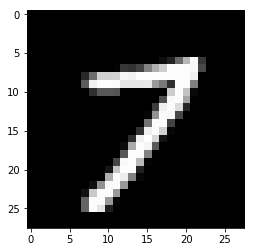

In [7]:
num_of_showimg = 9885
print("label : {}".format(t_train[num_of_showimg]))
img = Image.fromarray(np.uint8(x_train[num_of_showimg].reshape(28,28)))
plt.imshow(img)

### softmax

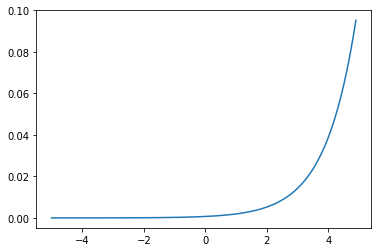

In [8]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x))

x = np.arange(-5.0, 5.0, 0.1)
y = softmax(x)
plt.plot(x,y)
#plt.ylim(-0.1,1.1)
plt.show()

### シグモイド

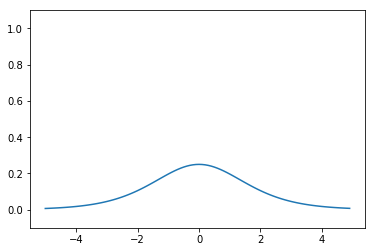

In [9]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

x = np.arange(-5.0, 5.0, 0.1)
y = sigmoid_grad(x)
plt.plot(x,y)
plt.ylim(-0.1,1.1)
plt.show()

### 損失関数

In [10]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

### 勾配の計算


In [11]:
def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 値を元に戻す
        it.iternext()   
        
    return grad

In [12]:
class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x:入力データ, t:教師データ
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x:入力データ, t:教師データ
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        dz1 = np.dot(dy, W2.T)
        da1 = sigmoid_grad(a1) * dz1
        grads['W1'] = np.dot(x.T, da1)
        grads['b1'] = np.sum(da1, axis=0)

        return grads

train acc, test acc | 0.17603333333333335, 0.1807


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


train acc, test acc | 0.8539666666666667, 0.8493
train acc, test acc | 0.8594833333333334, 0.8601
train acc, test acc | 0.8642333333333333, 0.8717
train acc, test acc | 0.86435, 0.8666
train acc, test acc | 0.8666333333333334, 0.8701
train acc, test acc | 0.8656833333333334, 0.8712
train acc, test acc | 0.8751, 0.8835
train acc, test acc | 0.8726833333333334, 0.8697
train acc, test acc | 0.8750333333333333, 0.8783
train acc, test acc | 0.8664333333333334, 0.8691
train acc, test acc | 0.878, 0.8802
train acc, test acc | 0.8692166666666666, 0.8715
train acc, test acc | 0.87995, 0.8815
train acc, test acc | 0.8822166666666666, 0.887
train acc, test acc | 0.86355, 0.8694
train acc, test acc | 0.8723, 0.8796


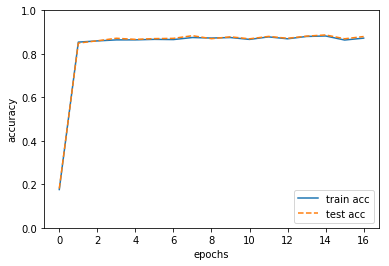

In [13]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000  # 繰り返しの回数を適宜設定する
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配の計算
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # パラメータの更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()
